#Clustering task for the earthquake dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import plotly.express as px

In [ ]:
data = pd.read_csv('quake.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [ ]:
data.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


In [ ]:
data.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Focal depth    0
Latitude       0
Longitude      0
Richter        0
dtype: int64


##EDA

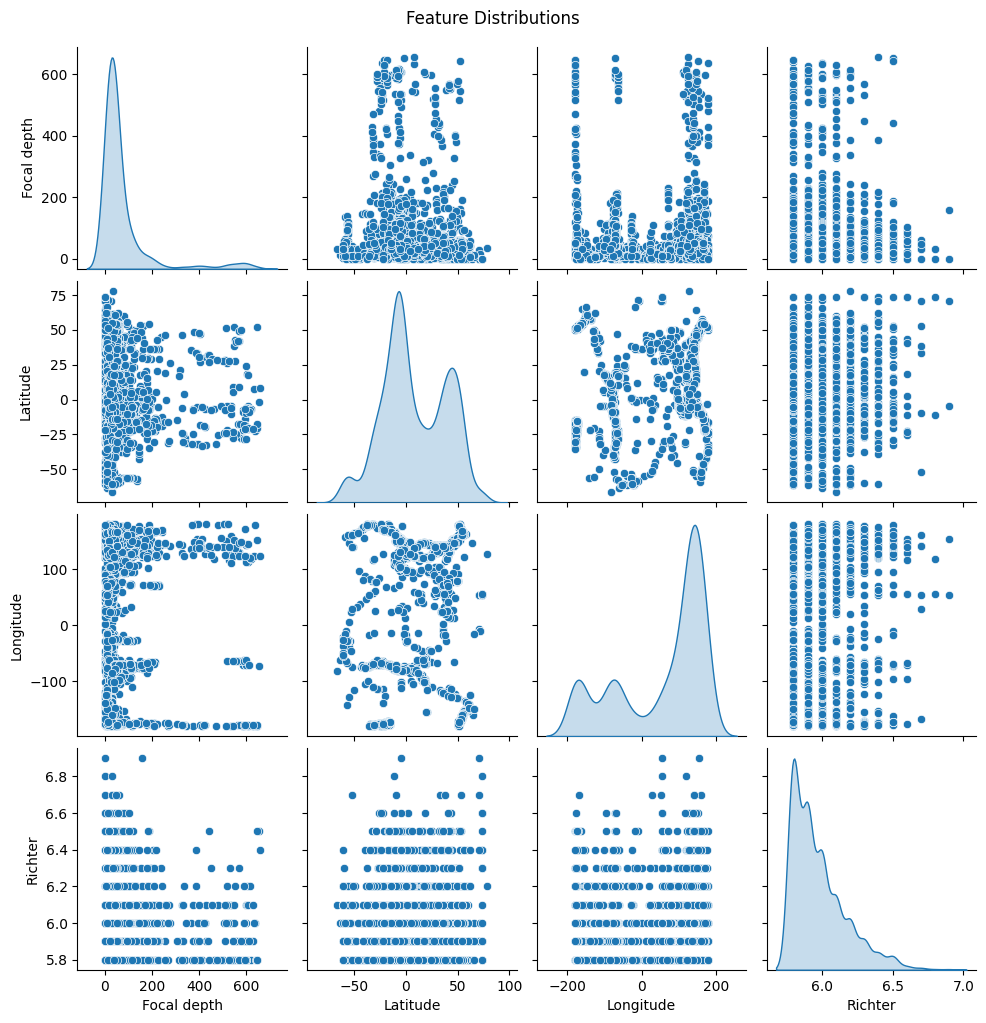

In [ ]:
sns.pairplot(data, diag_kind='kde')
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

Data scaling

In [ ]:
# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

Dimenzionality reduction

In [ ]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
print(f"Explained variance by PCA: {pca.explained_variance_ratio_}")

Explained variance by PCA: [0.30101647 0.25456905]


Scatterplot of PCA-reduced data

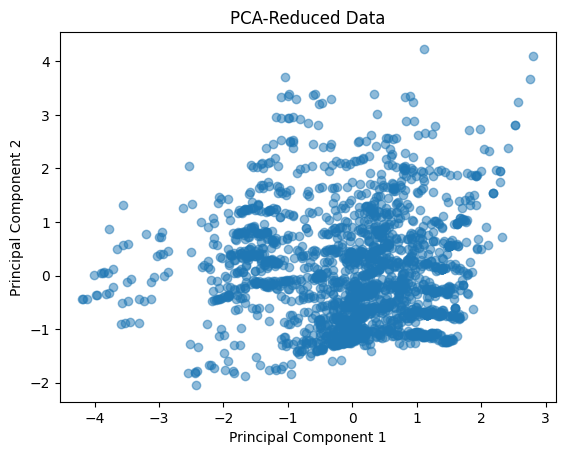

In [ ]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.title("PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

##k-Means Clustering and Evaluation

KMeans with 15 clusters

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)

Visualize k-means clusters in PCA-reduced space

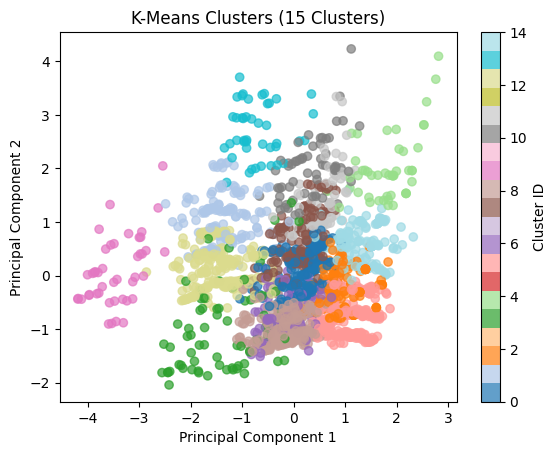

In [ ]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='tab20', alpha=0.7)
plt.title("K-Means Clusters (15 Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

###Determine optimal number of clusters

Method 1: Elbow Method

In [ ]:
inertia = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

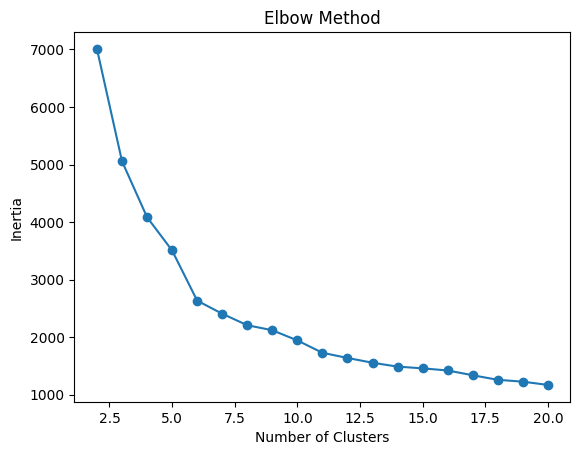

In [ ]:
plt.plot(range(2, 21), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Method 2: Silhouette Score

In [ ]:
sil_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    sil_scores.append(silhouette_score(data_scaled, labels))

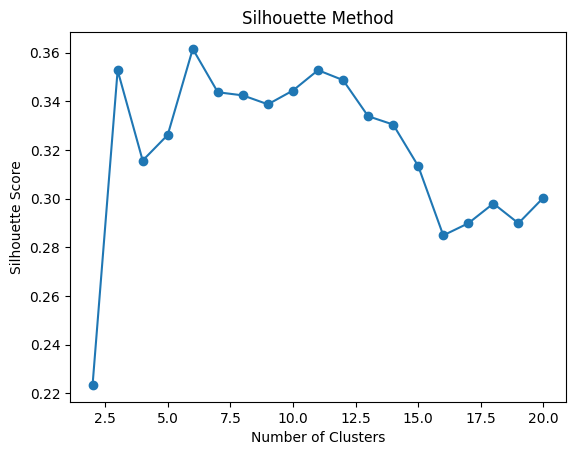

In [ ]:
plt.plot(range(2, 21), sil_scores, marker='o')
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


###Choose optimal k based on both methods


In [ ]:
kmeans_optimal = KMeans(n_clusters=6, random_state=42)
kmeans_optimal_labels = kmeans_optimal.fit_predict(data_scaled)

###Mini-Batch KMeans

In [ ]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters=6, random_state=42)
mini_batch_labels = mini_batch_kmeans.fit_predict(data_scaled)

###Compare KMeans and MiniBatch KMeans

In [ ]:
sil_kmeans = silhouette_score(data_scaled, kmeans_optimal_labels)
sil_mini_batch = silhouette_score(data_scaled, mini_batch_labels)

In [ ]:
print(f"Silhouette Score (KMeans): {sil_kmeans}")
print(f"Silhouette Score (MiniBatch KMeans): {sil_mini_batch}")

Silhouette Score (KMeans): 0.36156396489848264
Silhouette Score (MiniBatch KMeans): 0.3572900914654738


##Other Clustering Algorithms

###DBSCAN

In [ ]:
eps = 0.5
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(data_scaled)

###Agglomerative Clustering

In [ ]:
agglo = AgglomerativeClustering(n_clusters=6)
agglo_labels = agglo.fit_predict(data_scaled)

###Visualize DBSCAN and Agglomerative Clustering

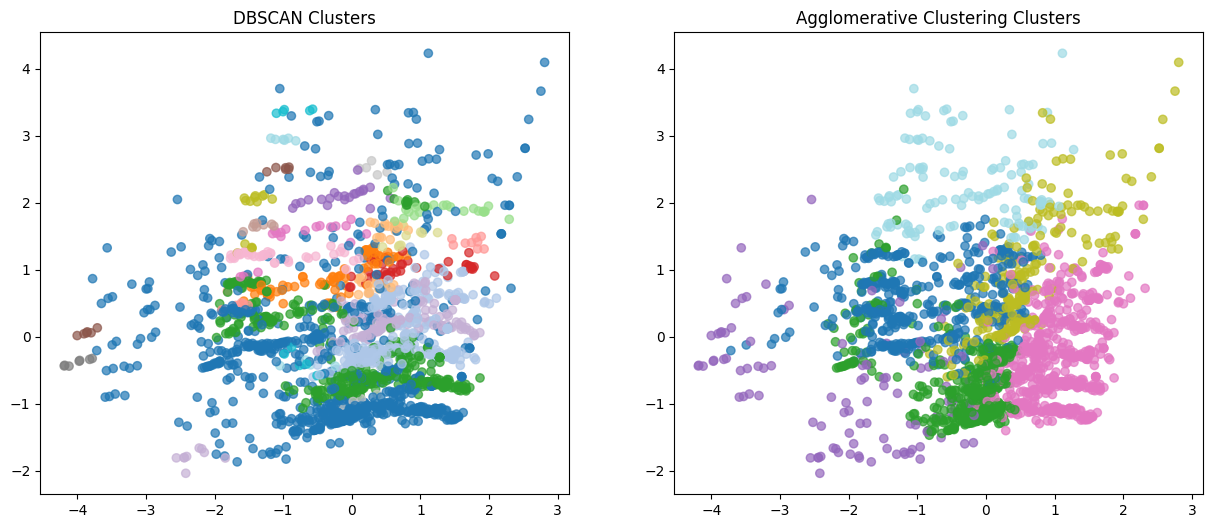

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='tab20', alpha=0.7)
axs[0].set_title("DBSCAN Clusters")

axs[1].scatter(data_pca[:, 0], data_pca[:, 1], c=agglo_labels, cmap='tab20', alpha=0.7)
axs[1].set_title("Agglomerative Clustering Clusters")
plt.show()

##Cluster Quality Metrics

###Internal Metrics

In [ ]:
sil_dbscan = silhouette_score(data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
sil_agglo = silhouette_score(data_scaled, agglo_labels)

calinski_kmeans = calinski_harabasz_score(data_scaled, kmeans_optimal_labels)
calinski_agglo = calinski_harabasz_score(data_scaled, agglo_labels)

print(f"Silhouette Score (DBSCAN): {sil_dbscan}")
print(f"Silhouette Score (Agglomerative): {sil_agglo}")
print(f"Calinski-Harabasz Score (KMeans): {calinski_kmeans}")
print(f"Calinski-Harabasz Score (Agglomerative): {calinski_agglo}")

Silhouette Score (DBSCAN): -0.15820315945233857
Silhouette Score (Agglomerative): 0.30622737211823203
Calinski-Harabasz Score (KMeans): 1002.1530735153685
Calinski-Harabasz Score (Agglomerative): 750.0327475624882


###External Metrics (use KMeans labels as ground truth)

In [ ]:
ari_dbscan = adjusted_rand_score(kmeans_optimal_labels, dbscan_labels)
ari_agglo = adjusted_rand_score(kmeans_optimal_labels, agglo_labels)

print(f"Adjusted Rand Index (DBSCAN): {ari_dbscan}")
print(f"Adjusted Rand Index (Agglomerative): {ari_agglo}")


Adjusted Rand Index (DBSCAN): 0.12963273227811745
Adjusted Rand Index (Agglomerative): 0.6045714983640954


##Best Algorithm Choice and Interpretation

Based on the above metrics, let's choose KMeans as the best algorithm for this task.

###Visualization on World Map

Create a GeoDataFrame

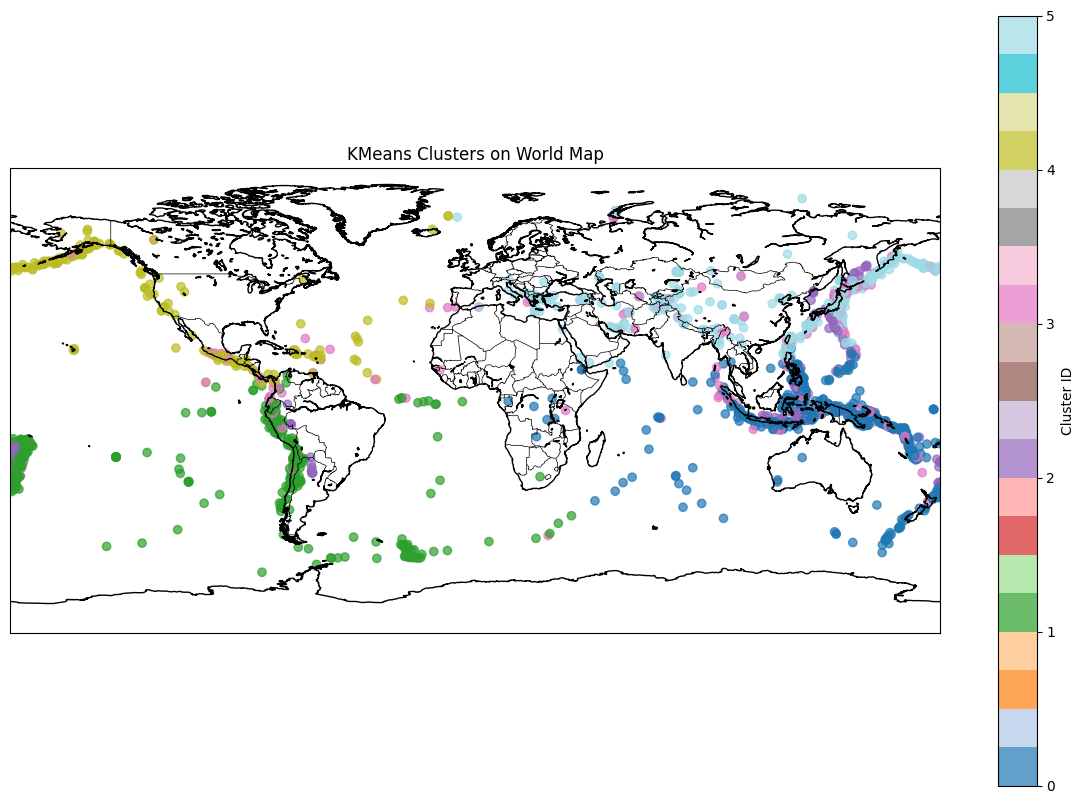

In [ ]:
# Example: Visualizing clusters on Basemap
plt.figure(figsize=(15, 10))
m = Basemap(projection='cyl', resolution='l')
m.drawcoastlines()
m.drawcountries()
scatter = m.scatter(
    data['Longitude'], data['Latitude'], c=kmeans_optimal_labels, cmap='tab20', latlon=True, alpha=0.7
)
plt.title("KMeans Clusters on World Map")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

In [ ]:
# Analyze average magnitude and depth per cluster
data['kmeans_labels'] = kmeans_optimal_labels
print(data.groupby('kmeans_labels')[['Richter', 'Focal depth']].mean())

                Richter  Focal depth
kmeans_labels                       
0              5.903188    57.295652
1              5.933243    61.451351
2              5.964912   517.842105
3              6.334915    50.915254
4              5.946154    30.338462
5              5.917315    38.356031
